In [ ]:
"""
###<u> **DEEP LEARNING PROGRAMMING ASSIGNMENT # 4** </u>
* **NAME = HASSAN JAVAID**
* **ROLL NO. = MSCS23001**
* **TASK01a = Image Mask Segmentation using UNet Model with skip connections**
* **TASK01b = Image Mask Segmentation using UNet Model without skip connections**
* **ALGORITHM used: UNet Model and Convolutional Neural Networks (CNNs)**
"""


# ================================================================
# ======================= Task 01-a & b ==========================
# ================================================================

import re
import os
import random
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset, DataLoader, Subset
from torchvision import transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors



In [ ]:
# ========================= START OF FUNCTION DEFINITIONS ====================

# Implements dataset file saving and loading
def saveDatasetToFile(filename, dataset):
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)


def loadDatasetFromFile(filename):
    with open(filename, 'rb') as f:
        loaded_dataset = pickle.load(f)
    return loaded_dataset


# Custom dataset class for Breast Cancer Datasets
class BreastCancerDataset(Dataset):
    def __init__(self, data, folder_path, label):
        self.data = data
        self.folder_path = folder_path
        self.transform = transform
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, mask_name = self.data[idx]
        image = Image.open(os.path.join(self.folder_path, img_name)).convert('L')
        mask = Image.open(os.path.join(self.folder_path, mask_name)).convert('L')
        label = self.label
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return (image, mask, label)


# Implements creation of Task-01 datasets from their respective folders
def createDataset(folder_path, label, transform=None, mask_transform=None):

    image_files = [file for file in os.listdir(folder_path) if file.endswith('.png')]
    data = process_data(image_files)
    return BreastCancerDataset(data, folder_path, label)


# Splits the image and mask filename and then processes it
def process_data(image_files, ext='.png'):
    data = []
    for image_file in image_files:
        f_split = re.split('[._]', image_file)
        if "mask" not in f_split:
            img_name = f_split[0] + ext
            mask_name = f_split[0] + "_mask" + ext
            data.append((img_name, mask_name))
    return data



# Implements saving and loading of the model
def saveModel(model_state_dict, filename):
    # if torch.cuda.is_available():
    #     model.to('cpu')  # Move model to CPU before saving if it's on GPU
    torch.save(model_state_dict, filename)

def loadModel(model, filename):
    if torch.cuda.is_available():
        # Load model on CPU first and then move it to GPU if available
        model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))
        model.to('cuda')
    else:
        model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))
    return model



# Implements training function with early stopping and learning rate decay
def trainModel(model, train_loader, val_loader, criterion, optimizer,
               threshold, weight_decay, num_epochs, max_early_stop,
               lr_decay_factor, patience, device):
#     STEPS:
#     1. Check for GPU availability
#     2. Define lists for storing training & validation loss and accuracy history
#     3. Use BinaryCrossEntropy and Dice Loss as loss function
#     4. Initailize learning rate decay scheduler and early_stopping_counter.
#     5. Calculate total loss as sum of BCE loss and dice-loss.
#     5. Iterate over train_loader & val_loader and calculate total loss and dice-score for each sample
#     6. If valid_loss is less than best_valid_loss, increase early_stopping_counter.
#     7. Update learning rate by decay factor using scheduler step in order to maximize dice-score.
#     8. Store the results in relevant lists.
#     9. Save the best model as defined by epoch_val_score.
#     9. Finish training after NUM_EPOCHS
#     10. Return Training/Validation loss and dice history

    print("Training & validation loop started... ")
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(device)
    best_valid_loss = float('inf')
    early_stopping_counter = 0

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=patience)
    train_dice_loss_history = []
    train_dice_score_history = []
    val_dice_loss_history = []
    val_dice_score_history = []

    total_train_samples = 0
    total_val_samples = 0
    best_dice = 0.0

    total_train_samples = sum(images.size(0) for images, _, _ in train_loader)
    print(f"Total Train Samples = {total_train_samples}")

    total_val_samples = sum(images.size(0) for images, _, _ in val_loader)
    print(f"Total Validation Samples = {total_val_samples}")
    print()

    for epoch in range(num_epochs):
        model.train()
        train_dice_loss = 0.0
        train_dice_score = 0.0

        # Training loop
        for images, true_masks, _ in train_loader:
            images, true_masks = images.to(device), true_masks.to(device)
            optimizer.zero_grad()
            pred_masks = model(images)

            loss = criterion(pred_masks, true_masks)
            loss += calculateDiceLoss(pred_masks, true_masks)

            train_dice_loss += loss.item()
            train_dice_score += calculateDiceScore(pred_masks, true_masks)

            loss.backward()
            optimizer.step()

        epoch_train_score = train_dice_score / len(train_loader)
        epoch_train_loss = train_dice_loss / len(train_loader)
        train_dice_score_history.append(convertToNumpy(epoch_train_score))
        train_dice_loss_history.append(epoch_train_loss)

        # Validation loop
        model.eval()
        val_dice_loss = 0.0
        val_dice_score = 0.0
        with torch.no_grad():
            for images, true_masks, _ in val_loader:
                images, true_masks = images.to(device), true_masks.to(device)
                pred_masks = model(images)

                loss = criterion(pred_masks, true_masks)
                loss += calculateDiceLoss(pred_masks, true_masks)
                val_dice_loss += loss.item()

                val_dice_score += calculateDiceScore(pred_masks, true_masks)


        epoch_val_score = val_dice_score / len(val_loader)
        epoch_val_loss = val_dice_loss / len(val_loader)
        val_dice_score_history.append(convertToNumpy(epoch_val_score))
        val_dice_loss_history.append(epoch_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Dice Score: {epoch_train_score:.4f}, Valid Loss: {epoch_val_loss:.4f}, Valid Dice Score: {epoch_val_score:.4f}")

        # Save best model
        if epoch_val_score > best_dice:
            best_dice = epoch_val_score
            best_epoch = epoch + 1
            best_model = model.state_dict()

        # Early stopping
        if epoch_val_loss < best_valid_loss:
            best_valid_loss = epoch_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= max_early_stop:
                print("Early stopping triggered!")
                return best_model, best_dice, best_epoch, train_dice_loss_history, val_dice_loss_history, train_dice_score_history, val_dice_score_history
                break

        # Learning rate decay
        scheduler.step(epoch_val_score)

    print("Training finished.")
    return best_model, best_dice, best_epoch, train_dice_loss_history, val_dice_loss_history, train_dice_score_history, val_dice_score_history



# Implements Dice Score calculation function
def calculateDiceScore(pred_mask, target_mask, eps=1e-7):
    assert pred_mask.size() == target_mask.size()
    intersection = torch.sum(pred_mask * target_mask)
    union = torch.sum(pred_mask) + torch.sum(target_mask)
    dice_score = (2. * intersection + eps) / (union + eps)
    return dice_score


# Implements Dice Loss calculation function
def calculateDiceLoss(pred_mask, target_mask, eps=1e-7):
    return 1 - calculateDiceScore(pred_mask, target_mask)



# Implements the movement of tensor to CPU and convert to NumPy array
def convertToNumpy(tensor):
    return tensor.cpu().detach().numpy()


# Implements the test function to evaluate our trained model
def evaluateModel(model, test_loader):
    model.eval()
    correct_preds = []
    wrong_preds = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Testing Loop
    with torch.no_grad():
        for batch_idx, (images, masks, _) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)

            # Generate predicted masks from test images
            predicted_masks = model(images)

            # Calculate dice score over each batch image and identify correct/incorrect predictions
            for image_idx in range(len(images)):
                dice_score = calculateDiceScore(predicted_masks[image_idx], masks[image_idx])
                if dice_score > 0.6:
                    # Correct pred
                    correct_preds.append((batch_idx, image_idx, images[image_idx], masks[image_idx], predicted_masks[image_idx], dice_score))
                else:
                    # Wrong pred
                    wrong_preds.append((batch_idx, image_idx, images[image_idx], masks[image_idx], predicted_masks[image_idx], dice_score))
    return (correct_preds, wrong_preds)


# Create custom dataset with specified number of images from each class
def genSubsetData(dataloader, numImages=50):
    class_indices = {0: 0, 1: 0, 2: 0}
    subset_data = []

    for images, masks, labels in dataloader:
        for image, mask, label in zip(images, masks, labels):
            if label.item() in class_indices and class_indices[label.item()] < numImages:
                subset_data.append((image, mask, label))
                class_indices[label.item()] += 1
            if all(count >= numImages for count in class_indices.values()):
                break
        if all(count >= numImages for count in class_indices.values()):
            break

    return subset_data


# ==========================================================================================
# Implements trained_model plotting and visualization functions on train/valid/test datasets
# ==========================================================================================

# Implements plotting of train and validation dataset loss and accuracy curves
def plotTrainValidHistory(train_loss, valid_loss, train_acc, valid_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train', color='blue', linestyle='-')
    plt.plot(epochs, valid_loss, label='Validation', color='orange', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.ylim(0.05, 2.05)
    plt.grid(True)
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train', color='blue', linestyle='-')
    plt.plot(epochs, valid_acc, label='Validation', color='orange', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.title('Dice Coefficient Curve')
    plt.ylim(0.05, 1)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.draw()


# Implements visualization of test predictions
def visualizePredictions(predictions, test_loader, num_samples=5, threshold=0.5):
    num_cols = 3
    num_rows = 5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

    selected_samples = np.random.choice(len(predictions), min(num_samples, len(predictions)), replace=False)

    for row_idx in range(num_rows):
        idx = selected_samples[row_idx]
        # print(idx)
        batch_idx, image_idx, image, original_mask, predicted_mask, dice_score = predictions[idx]

        image_np, original_mask_np, predicted_mask_np = map(convertToNumpy, (image, original_mask,
                                                                    predicted_mask))
        # Original Image
        axes[row_idx, 0].imshow(np.transpose(image_np, (1, 2, 0)))
        axes[row_idx, 0].set_title('Original Image')
        axes[row_idx, 0].axis('off')

        # Original Mask
        axes[row_idx, 1].imshow(original_mask_np.squeeze(), cmap='gray')
        axes[row_idx, 1].set_title('Original Mask')
        axes[row_idx, 1].axis('off')

        # Predicted Mask
        predicted_mask_np = (predicted_mask_np > threshold)
        axes[row_idx, 2].imshow(predicted_mask_np.squeeze(), cmap='gray')
        axes[row_idx, 2].set_title(f'Predicted Mask with Dice Score: {dice_score:.4f}')
        axes[row_idx, 2].axis('off')

    plt.tight_layout()
    plt.draw()

# Implements plotting of sample images from dataloader
def plotSampleImage(dataloader, suptitle, oneHot=False):
    dataset = dataloader.dataset
    random_idx = random.randint(0, len(dataset) - 1)
    img, mask, label = dataset[random_idx]
    transform = transforms.Grayscale()

    if int(label) == 0:
        title = "Normal Class"
    elif int(label) == 1:
        title = "Benign Class"
    else:
        title = "Malignant Class"

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(transform(img).squeeze(), cmap="gray")
    ax.set_title(f"{title}, Label: {label}", fontsize=14)
    ax.axis('off')

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(transform(mask).squeeze(), cmap="gray")
    ax.set_title(f"{title}, Label: {label}", fontsize=14)
    ax.axis('off')

    fig.suptitle(suptitle, fontsize=16, fontweight='bold', color='blue')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.draw()



# Implements functionlity for real-time image preprocessing and class prediction
def preprocessImage(image_path, image_size=128):
    img = Image.open(image_path).convert('L')

    # Define transformations to be applied to the image
    transform = transforms.Compose([
        # transforms.Grayscale(num_output_channels=1),    # Convert to grayscale
        transforms.Resize((image_size, image_size)),    # Resize to image_size
        transforms.ToTensor(),                          # Convert to tensor
    ])

    # Apply transformations to the image
    img_processed = transform(img).unsqueeze(0) # Add batch dimension

    return img_processed

def predictImageMask(image_path, original_mask_path, model, threshold=0.5):
    # Preprocess the image
    image = preprocessImage(image_path)
    original_mask = preprocessImage(original_mask_path)
    model.eval()

    # Perform prediction
    with torch.no_grad():
        predicted_mask = model(image)
        dice_score = calculateDiceScore(predicted_mask, original_mask)
        print(f"Dice score for input image: {dice_score}")
        fig, axes = plt.subplots(1, 3, figsize=(15, 3))

        image_np = image.cpu().detach().numpy().squeeze(0)
        original_mask_np = original_mask.cpu().detach().numpy().squeeze(0)
        predicted_mask_np = predicted_mask.cpu().detach().numpy()
        # print(image_np.shape)

        # Original Image
        axes[0].imshow(np.transpose(image_np, (1, 2, 0)))
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Original Mask
        axes[1].imshow(original_mask_np.squeeze(), cmap='gray')
        axes[1].set_title('Original Mask')
        axes[1].axis('off')

        # Predicted Mask
        predicted_mask_np = (predicted_mask_np > threshold)
        axes[2].imshow(predicted_mask_np.squeeze(), cmap='gray')
        axes[2].set_title(f'Predicted Mask with Dice Score: {dice_score:.4f}')
        axes[2].axis('off')

        plt.suptitle("Image Mask Prediction")
        plt.tight_layout()
        plt.draw()


# Make t-SNE plot for the encoded data
def genTSNEplot(encoder, subset_data):
    encoded_data = [encoder(image.unsqueeze(0)).detach().numpy().flatten() for image, _, _ in subset_data]
    encoded_data = np.array(encoded_data)

    labels = [label for _, _, label in subset_data]

    tsne = TSNE(n_components=2, random_state=21)
    tsne_data = tsne.fit_transform(encoded_data)

    # Plot t-SNE embeddings
    colors = ['#A52A2A', '#40E0D0', '#FF00FF']
    cmap = mcolors.ListedColormap(colors)
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], marker='.', c=labels, cmap=cmap)
    plt.title('t-SNE Plot of Encoder Output')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    cbar = plt.colorbar(label='Breastcancer Class')
    cbar.set_ticks([0, 1, 2])
    plt.show()


# ======================= END OF FUNCTION DEFINTIONS ====================================


In [ ]:
# ========================= START OF UNET MODEL CLASSES ==================================

# Implements double conv layer consisting of Conv23 => BatchNorm => ReLU
class InDoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.in_conv(x)

# Implements encoder stage downscaling and then double conv to encode input
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            InDoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Implements decoder stage upscaling and then double conv the encoded input
class Up(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = InDoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Implements final output conv layer in UNet
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class Task1a_UNetModel(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Task1a_UNetModel, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            InDoubleConv(n_channels, 64),    # (convolution => [BN] => ReLU) * 2
            Down(64, 128),                    # Downscaling => Maxpool => InDoubleConv
            Down(128, 256),
            Down(256, 512),
            Down(512, 1024)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            Up(1024, 512),                   # Upscaling => Upsample => InDoubleConv
            Up(512, 256),
            Up(256, 128),
            Up(128, 64)
        )

        self.output = OutConv(64, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder Stage
        x1 = self.encoder[0](x)
        x2 = self.encoder[1](x1)
        x3 = self.encoder[2](x2)
        x4 = self.encoder[3](x3)
        x5 = self.encoder[4](x4)

        # Decoder Stage
        x = self.decoder[0](x5, x4)                # Skip connections implemented
        x = self.decoder[1](x, x3)
        x = self.decoder[2](x, x2)
        x = self.decoder[3](x, x1)
        out_logits = self.output(x)
        final = self.sigmoid(out_logits)    # Final sigmoid for limiting out-range

        return final



# Task-1b: Implements decoder stage upscaling and then double conv the encoded input
class Up_1b(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.conv = InDoubleConv(in_channels, out_channels)

    def forward(self, x1):
        x1 = self.up(x1)
        return self.conv(x1)


class Task1b_UNetModel(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Task1b_UNetModel, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            InDoubleConv(n_channels, 64),    # (convolution => [BN] => ReLU) * 2
            Down(64, 128),                    # Downscaling => Maxpool => InDoubleConv
            Down(128, 256),
            Down(256, 512),
            Down(512, 1024)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            Up_1b(1024, 512),               # Upscaling => ConvTranspose2d => InDoubleConv
            Up_1b(512, 256),
            Up_1b(256, 128),
            Up_1b(128, 64)
        )

        self.output = OutConv(64, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder Stage
        x1 = self.encoder[0](x)
        x2 = self.encoder[1](x1)
        x3 = self.encoder[2](x2)
        x4 = self.encoder[3](x3)
        x5 = self.encoder[4](x4)

        # Decoder Stage
        x6 = self.decoder[0](x5)                # No skip connections
        x7 = self.decoder[1](x6)
        x8 = self.decoder[2](x7)
        x9 = self.decoder[3](x8)

        out_logits = self.output(x9)
        final = self.sigmoid(out_logits)    # Final sigmoid for limiting out-range

        return final

# ============================ END OF UNET MODEL CLASSES ===================================


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


cuda
Normal dataset length: 133
Benign dataset length: 440
Malignant dataset length: 210

Train dataset length: 548
Valid dataset length: 156
Test dataset length: 79

Training & validation loop started... 
cuda
Total Train Samples = 548
Total Validation Samples = 156

Epoch [1/100], Train Loss: 1.5877, Train Dice Score: 0.2444, Valid Loss: 1.8023, Valid Dice Score: 0.2092
Epoch [2/100], Train Loss: 1.3360, Train Dice Score: 0.4040, Valid Loss: 1.7494, Valid Dice Score: 0.2201
Epoch [3/100], Train Loss: 1.1467, Train Dice Score: 0.5543, Valid Loss: 1.1919, Valid Dice Score: 0.5191
Epoch [4/100], Train Loss: 1.0567, Train Dice Score: 0.6320, Valid Loss: 1.4017, Valid Dice Score: 0.3763
Epoch [5/100], Train Loss: 1.0606, Train Dice Score: 0.6295, Valid Loss: 1.1460, Valid Dice Score: 0.5644
Epoch [6/100], Train Loss: 1.0237, Train Dice Score: 0.6640, Valid Loss: 1.1248, Valid Dice Score: 0.5845
Epoch [7/100], Train Loss: 1.0249, Train Dice Score: 0.6607, Valid Loss: 1.0999, Valid Dice Sco

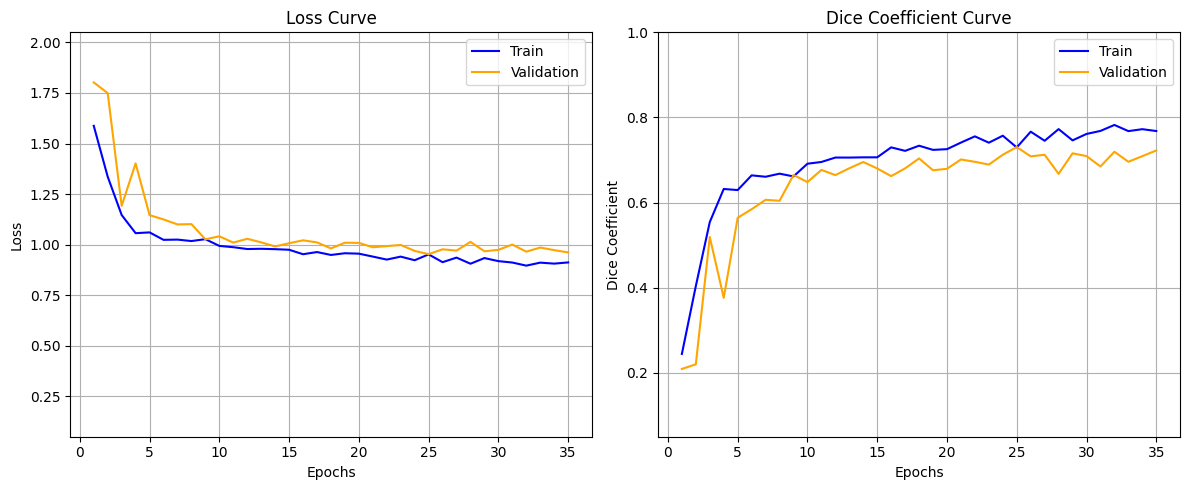

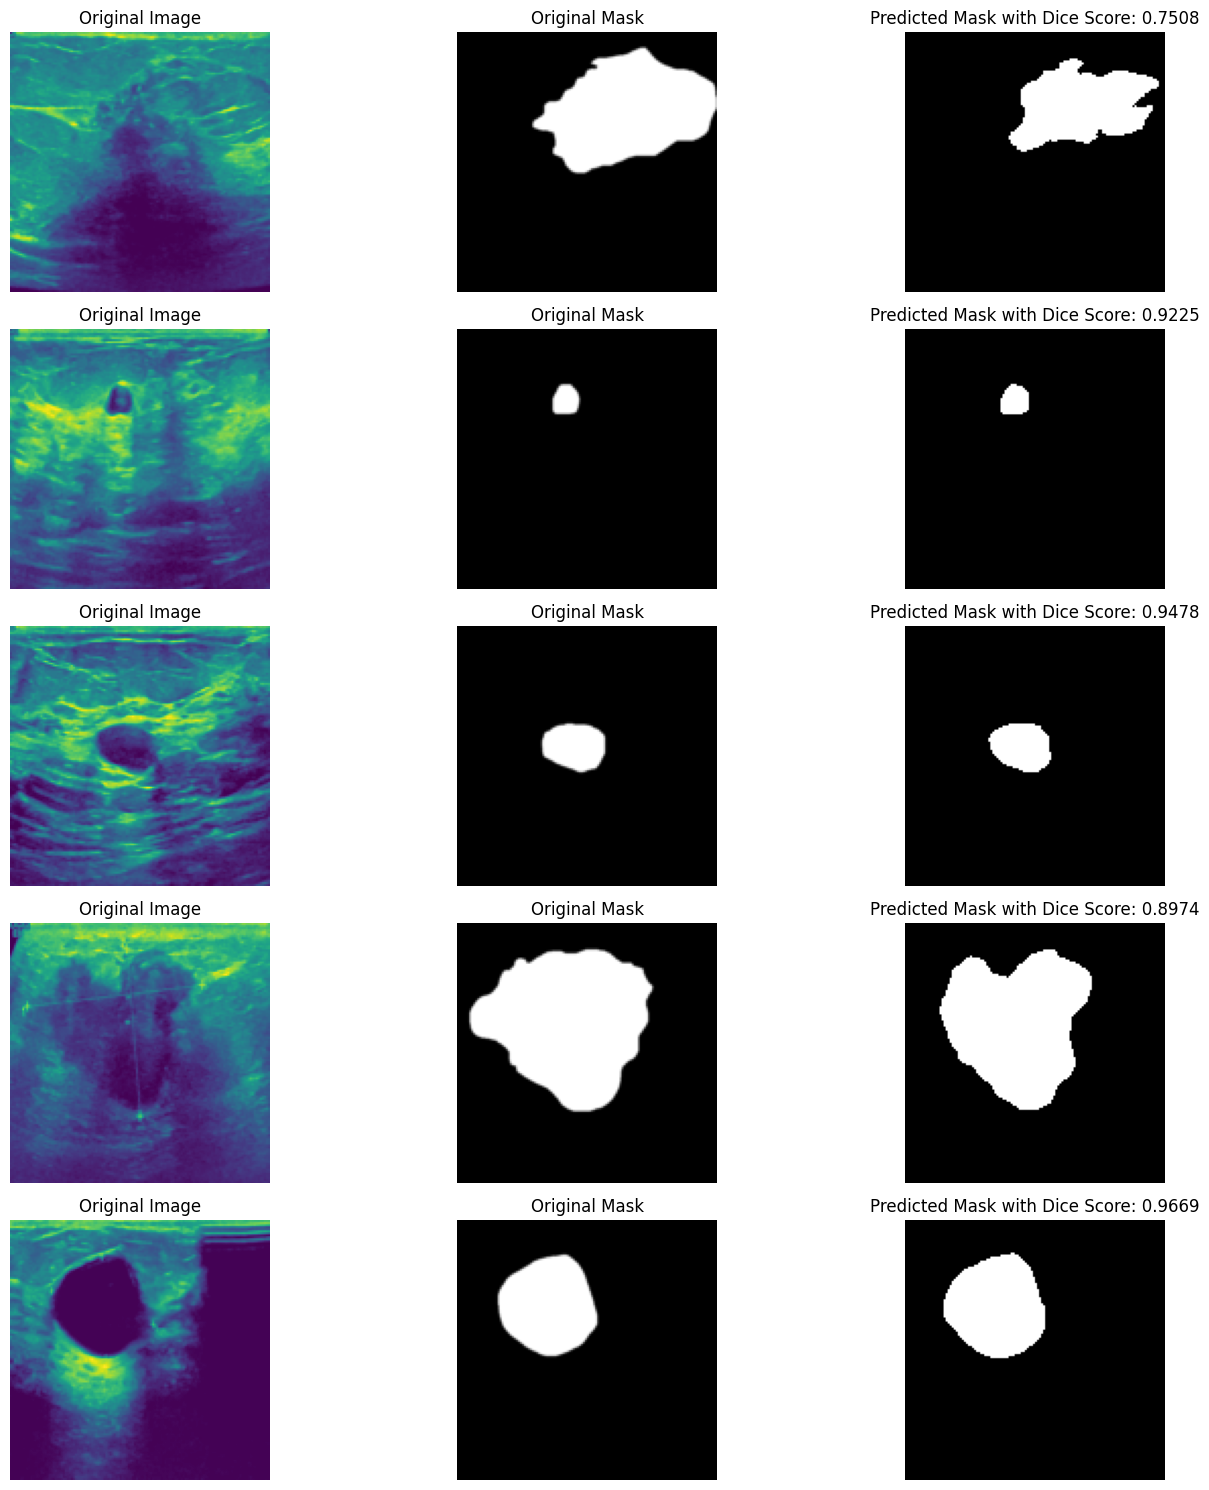

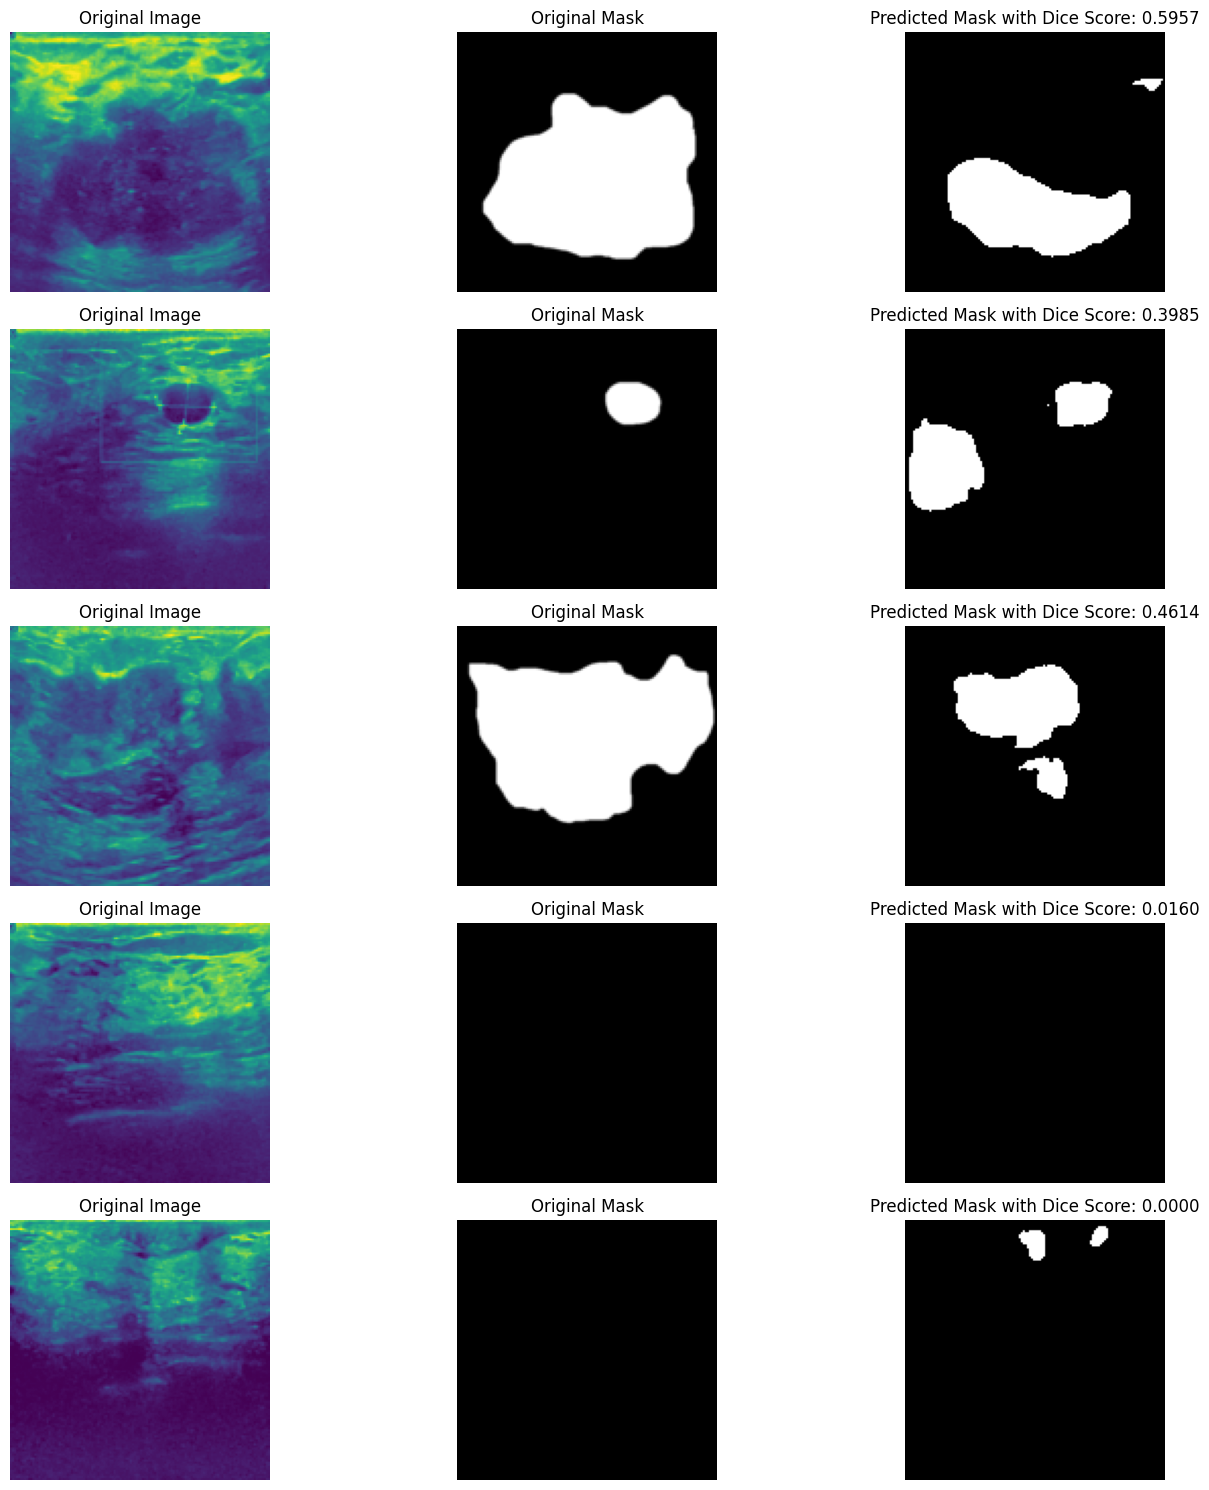

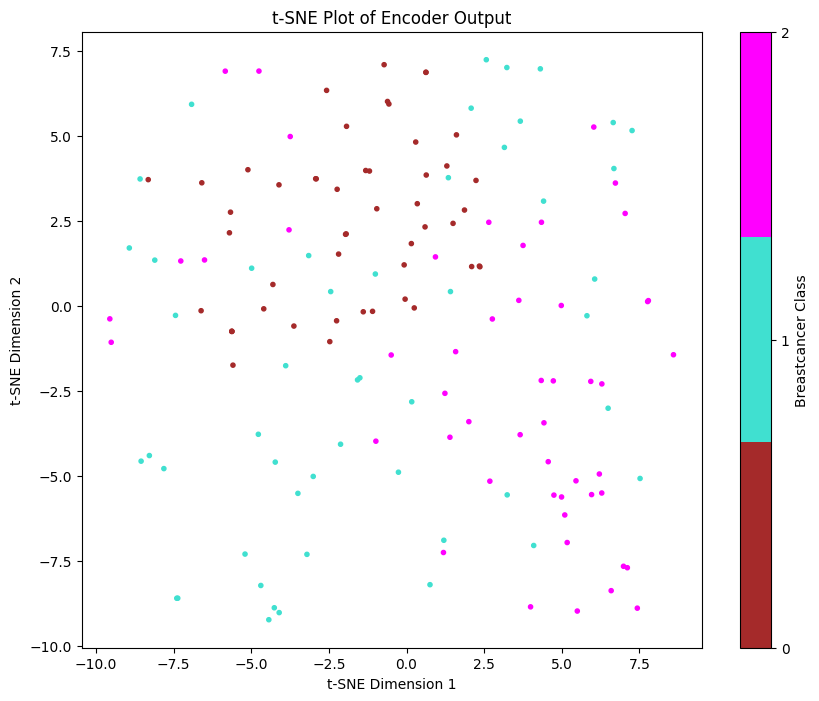

Dice score for input image: 0.7092931270599365


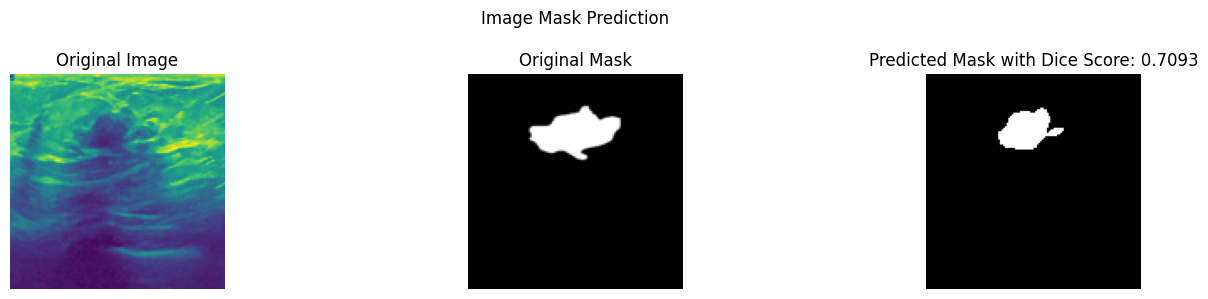

In [ ]:
# ====================================== Main Function =====================================

if __name__ == '__main__':
    # Change ROOT_DIR to desired path name
    ROOT_DIR = "/content/drive/MyDrive/Dataset_BUSI_with_GT"

    # Define image class folders
    benign_folder = ROOT_DIR + "/" + "benign"
    malignant_folder = ROOT_DIR + "/" + "malignant"
    normal_folder = ROOT_DIR + "/" + "normal"


    # Define hyper parameters
    BATCH_SIZE = 16
    NUM_EPOCHS = 100
    EARLY_STOP_FACTOR = 10
    IMAGE_SIZE = 128
    # DROPOUT_RATE = 0.5
    LR_DECAY_FACTOR = 0.005
    LEARNING_RATE = 1e-5
    WEIGHT_DECAY = 1e-6
    MOMENTUM = 0.999
    THRESHOLD = 0.5
    PATIENCE = 10
    RANDOM_SEED = 42

    # Check device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ])

    normal_dataset = createDataset(normal_folder, 0, transform=transform)
    benign_dataset = createDataset(benign_folder, 1, transform=transform)
    malignant_dataset = createDataset(malignant_folder, 2, transform=transform)

    print(f"Normal dataset length: {len(normal_dataset)}")
    print(f"Benign dataset length: {len(benign_dataset)}")
    print(f"Malignant dataset length: {len(malignant_dataset)}")
    print()

    # Combine the three datasets into a single dataset
    combined_dataset = ConcatDataset([normal_dataset, benign_dataset, malignant_dataset])

    # Define the sizes for train, validation, and test splits
    train_size = 0.7
    valid_size = 0.2
    test_size = 0.1

    # Shuffle the combined dataset using a random seed
    random_seed = RANDOM_SEED
    torch.manual_seed(random_seed)
    shuffled_indices = torch.randperm(len(combined_dataset))

    # Split the shuffled dataset into train, validation, and test datasets
    train_indices, temp_indices = train_test_split(shuffled_indices, test_size=valid_size + test_size, random_state=random_seed)
    valid_test_indices = temp_indices.tolist()
    valid_indices, test_indices = train_test_split(valid_test_indices, test_size=test_size / (valid_size + test_size), random_state=random_seed)

    # Prepare datasets for train, valid and test datasets
    train_dataset = Subset(combined_dataset, train_indices)
    valid_dataset = Subset(combined_dataset, valid_indices)
    test_dataset = Subset(combined_dataset, test_indices)

    print(f"Train dataset length: {len(train_dataset)}")
    print(f"Valid dataset length: {len(valid_dataset)}")
    print(f"Test dataset length: {len(test_dataset)}")
    print()

    # Prepare Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


    # # ==================================================================================================================
    # # # # Save the datasets for future uses in training to avoid reloading dataset every time (optional)
    # # # Dataset save file names
    # TRAIN_DATASET_SAVE_NAME = ROOT_DIR + "/" + "train_dataset_task01.pkl"
    # VAL_DATASET_SAVE_NAME = ROOT_DIR + "/" + "val_dataset_task01.pkl"
    # TEST_DATASET_SAVE_NAME = ROOT_DIR + "/" + "test_dataset_task01.pkl"
    # # ==================================================================================================================


    # # Define UNet model with skip connections for Task-1a
    model = Task1a_UNetModel(n_channels=1, n_classes=1)

    # # Define UNet model without skip connections for Task-1b
    # model = Task1b_UNetModel(n_channels=1, n_classes=1)

    # # print(model)
    # summary(model, (1, 128, 128))

    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE,
                            weight_decay=WEIGHT_DECAY, momentum=MOMENTUM,
                            foreach=True)

    # Train the model with early stopping and learning rate decay
    trained_model, best_dice, best_epoch, train_loss_history, val_loss_history, train_acc_history, val_acc_history = trainModel(model, train_loader, valid_loader, criterion,
                             optimizer, THRESHOLD, WEIGHT_DECAY, NUM_EPOCHS,
                             EARLY_STOP_FACTOR, LR_DECAY_FACTOR,
                             PATIENCE, device)

    # Plot the loss and dice curves for train and valid datasets
    plotTrainValidHistory(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

    # Save the trained model for future use
    filename = f"trained_modeltask01a_06_epoch{best_epoch}_dice{int(best_dice)}.pth"
    SAVE_MODEL_FILE_NAME = ROOT_DIR + "/" + filename
    saveModel(trained_model, SAVE_MODEL_FILE_NAME)

    # Load the trained model for testing
    LOAD_MODEL_FILE_NAME = SAVE_MODEL_FILE_NAME
    new_model = Task1a_UNetModel(n_channels=1, n_classes=1)
    loaded_model = loadModel(new_model, LOAD_MODEL_FILE_NAME)

    correct_preds, wrong_preds = evaluateModel(loaded_model, test_loader)

    # Visualize correct predictions
    print("Correct Predictions:")
    visualizePredictions(correct_preds, test_loader, num_samples=5)
    # Visualize wrong predictions
    print("Wrong Predictions:")
    visualizePredictions(wrong_preds, test_loader, num_samples=5)
    print()

    # Check model devices
    model_device = next(loaded_model.parameters()).device
    input_device = next(iter(train_loader))[0].device
    print("Model device:", model_device)
    print("Input data device:", input_device)
    loaded_model.to(input_device) # Update model device to match input device
    subset_data = genSubsetData(train_loader)
    genTSNEplot(loaded_model.encoder, subset_data)

    # Check our model on real-time input
    TEST_IMAGE_PATH = "/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (100).png"
    TEST_MASK_PATH = "/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (100)_mask.png"
    predictImageMask(TEST_IMAGE_PATH, TEST_MASK_PATH, loaded_model)

#End of Code